
# Gaussian Dirichlet Approximation

In [1]:
import torch
from torch.distributions.dirichlet import Dirichlet
from torch.distributions import Normal
from torch.nn import functional as F
#
import matplotlib.pyplot as plt
import ternary
#
from tqdm import tqdm

In [2]:
def alphas_to_normal_params(alphas):
    d_t = alphas.shape[0]
    mu = torch.log(alphas) - (1/d_t) * torch.log(alphas).sum()
    sigma = (1 / alphas) * (1 - 2 /d_t) + (1 / d_t**2) * torch.sum(1/alphas)
    std = torch.sqrt(sigma)
    return mu, std

### Visualize

In [3]:
d_t = 3 # dimensin
#
alphas = torch.Tensor((.01, .01, .01))
alphas = torch.Tensor((0.5, 0.5, 0.5))
alphas = torch.Tensor((100, 50, 10))
#alphas = torch.rand(d_t)

In [4]:
mu, std = alphas_to_normal_params(alphas)

In [5]:
n_samples = 1000
#
dist_dirichlet = Dirichlet(alphas)
dist_normal = Normal(mu, std)
#
x_normal = dist_normal.sample((n_samples,))
x_normal = F.softmax(x_normal, dim=1)
#
x_dirichlet = dist_dirichlet.sample((n_samples, ))

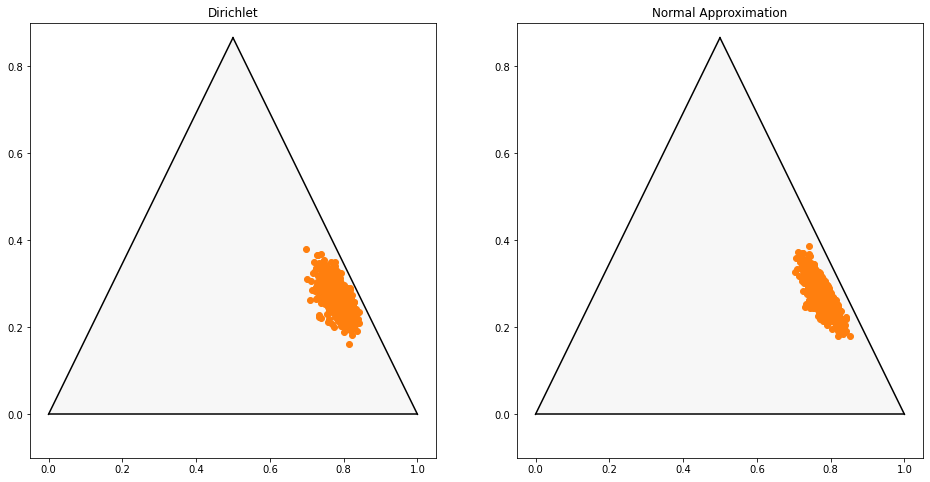

In [6]:
figure, axes = plt.subplots(1, 2, figsize=(16, 8))

tax0 = ternary.TernaryAxesSubplot(ax=axes[0])
tax1 = ternary.TernaryAxesSubplot(ax=axes[1])
#
tax0.scatter(x_dirichlet.numpy(), label="Dirichlet")
tax0.boundary()
tax0.set_title("Dirichlet")

tax1.scatter(x_normal.numpy(), label="Normal")
tax1.boundary()
tax1.set_title("Normal Approximation")

In [7]:
dist_dirichlet.log_prob(x_dirichlet).mean()

tensor(4.4721)

In [8]:
dist_dirichlet.log_prob(x_normal).mean()

tensor(4.5418)

### Loglikelihood over n samples and random alphas

In [9]:
d_t = 100
n_samples = 1000
n_tries = 100
all_diffs = []

step = 100
start = 10
end = 10000
all_samples = torch.arange(start, end + step + start, step)

for n_samples in tqdm(all_samples):
    diffs = []
    for _ in range(n_tries):
        alphas = torch.rand(d_t)
        #
        mu, std = alphas_to_normal_params(alphas)
        #
        x_normal = dist_normal.sample((n_samples,))
        x_normal = F.softmax(x_normal, dim=1)
        #
        x_dirichlet = dist_dirichlet.sample((n_samples, ))
        #
        ll_dir = dist_dirichlet.log_prob(x_dirichlet).mean()
        ll_nor = dist_dirichlet.log_prob(x_normal).mean()
        diff = torch.abs(ll_nor - ll_dir)
        diffs.append(diff.item())
    diff = torch.Tensor(diffs).mean()
    all_diffs.append(diff)

100%|██████████| 101/101 [00:24<00:00,  4.20it/s]


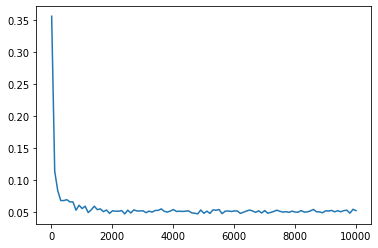

In [10]:
plt.plot(all_samples, all_diffs)

# Reparametrization of Normal

In [11]:
def reparametrize_sample_normal(mu, std):
    eps = torch.randn_like(std) # from N(0, 1)
    z = std * eps + mu
    return z

In [12]:
d_t = 2

mu = torch.rand(d_t)
std = torch.rand(d_t)
#
dist_normal = Normal(mu, std)
#
n_samples = 1000
x_normal = torch.stack([reparametrize_sample_normal(mu, std) for _ in range(n_samples)])
x_repara = dist_normal.sample((n_samples,))

In [13]:
dist_normal.log_prob(x_normal).mean()

tensor(0.6606)

In [14]:
dist_normal.log_prob(x_repara).mean()

tensor(0.6336)

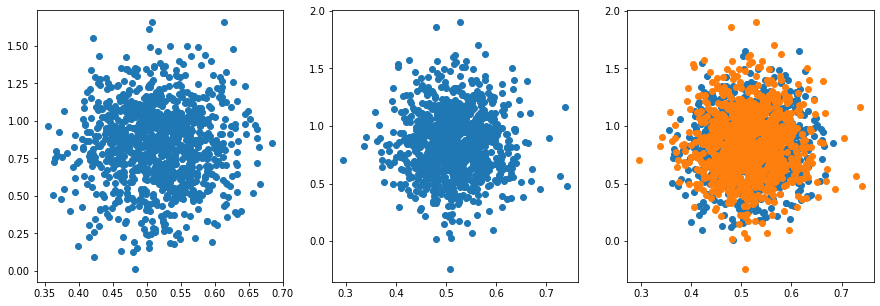

In [15]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

axes[0].scatter(x_normal[:, 0], x_normal[:, 1])
axes[1].scatter(x_repara[:, 0], x_repara[:, 1])

axes[2].scatter(x_normal[:, 0], x_normal[:, 1])
axes[2].scatter(x_repara[:, 0], x_repara[:, 1])

# Normal vs multivariate normal

In [16]:
import torch
from torch.distributions import Normal
from torch.distributions import MultivariateNormal
from torch.nn import functional as F
#
import matplotlib.pyplot as plt
import ternary
#
from tqdm import tqdm

In [17]:
n_d = 2
mu = torch.rand(n_d)
std = torch.rand(n_d)
cov = torch.diag(std**2)
#
dist_normal = Normal(mu, std)
dist_multin = MultivariateNormal(mu, cov)

In [18]:
x = dist_normal.sample()
print(dist_normal.log_prob(x).sum())
print(dist_multin.log_prob(x))

tensor(-1.9333)
tensor(-1.9333)


# Reparametrize MultivariateNormal

In [19]:
def reparametrize_sample_normal(mu, std):
    eps = torch.randn_like(std) # from N(0, 1)
    z = std * eps + mu
    return z

In [20]:
n_d = 2
mu = torch.rand(n_d) + 4
std = torch.rand(n_d) + 1
cov = torch.diag(std**2)
#
dist_normal = Normal(mu, std)
dist_multin = MultivariateNormal(mu, cov)
#
n_samples = 1000
x_normal = torch.stack([reparametrize_sample_normal(mu, std) for _ in range(n_samples)])
x_repara = dist_normal.sample((n_samples,))
x_multin = dist_multin.sample((n_samples,))

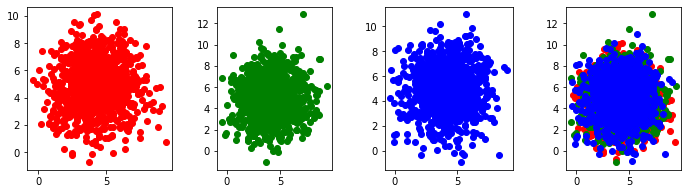

In [21]:
fig, axes = plt.subplots(1, 4, figsize=(12, 3))

for ax in axes:
    ax.set_aspect('equal')

axes[0].scatter(x_normal[:, 0], x_normal[:, 1], c="red")
axes[1].scatter(x_repara[:, 0], x_repara[:, 1], c="green")
axes[2].scatter(x_multin[:, 0], x_multin[:, 1], c="blue")

axes[3].scatter(x_normal[:, 0], x_normal[:, 1], c="red")
axes[3].scatter(x_repara[:, 0], x_repara[:, 1], c="green")
axes[3].scatter(x_multin[:, 0], x_multin[:, 1], c="blue")

# MMG logprob and sampling

### sampling  from MMG

In [22]:
mus = torch.Tensor([[-1, -1],
                    [2, 5],
                    [-4, 3]])
stds = torch.Tensor([[0.1, 0.1],
                    [0.1 , 0.1],
                    [0.1, 0.1]])
covs = [torch.diag(std**2) for std in stds]
p_norms = [MultivariateNormal(mu, cov) for mu, cov in zip(mus, covs)]

In [23]:
n_samples = 4
h = torch.Tensor([[1, 0, 0],
                  [0, 1, 0],
                  [0, 0, 1],
                  [1, 0, 0]])
y = torch.stack([p_norm.sample((n_samples, )) for p_norm in p_norms], axis=1)
y.shape

torch.Size([4, 3, 2])

In [24]:
y[0][0], y[1][1], y[2][2], y[3][0]

(tensor([-0.8916, -1.1022]),
 tensor([2.1389, 5.1385]),
 tensor([-4.1402,  2.8464]),
 tensor([-0.9895, -1.1189]))

In [25]:
y = torch.einsum('btd, bt -> bd', y, h)
y

tensor([[-0.8916, -1.1022],
        [ 2.1389,  5.1385],
        [-4.1402,  2.8464],
        [-0.9895, -1.1189]])

### logprob of MMG

In [26]:
lp_norms = [torch.exp(p_norm.log_prob(y)) for p_norm in p_norms]
lp_norms

[tensor([5.2462, 0.0000, 0.0000, 7.8044]),
 tensor([0.0000, 2.3238, 0.0000, 0.0000]),
 tensor([0.0000, 0.0000, 1.8318, 0.0000])]

In [27]:
lp_norms = torch.stack(lp_norms, axis=1)
print(lp_norms.shape)
lp_norms

torch.Size([4, 3])


tensor([[5.2462, 0.0000, 0.0000],
        [0.0000, 2.3238, 0.0000],
        [0.0000, 0.0000, 1.8318],
        [7.8044, 0.0000, 0.0000]])

In [28]:
lp_norms = torch.einsum("bt, bt -> b", lp_norms, h)
lp_norms

tensor([5.2462, 2.3238, 1.8318, 7.8044])

In [29]:
lp_norms.log()

tensor([1.6575, 0.8432, 0.6053, 2.0547])

### Putting things together

In [373]:
class MMG():
    def __init__(self, mus, stds, alphas):
        self.mus = mus
        self.stds = stds
        self.alphas = alphas
        #
        self.covs = [torch.diag(std**2) for std in stds]
        #
        self.p_norms = [MultivariateNormal(mu, cov) for mu, cov in zip(self.mus, self.covs)]
        self.p_diric = Dirichlet(self.alphas)

    def sample(self, n=1):
        h = self.p_diric.sample((n,))
        yi = torch.stack([p_norm.sample((n, )) for p_norm in self.p_norms], axis=1)
        y = torch.einsum('btd, bt -> bd', yi, h)
        return y, h
    
    def log_prob(self, y, h):
        lp_diric = self._log_prob_dirichlet(h)
        lp_norms = self._log_prob_normals(y, h)

        lp = lp_norms + lp_diric
        return lp
    
    def _log_prob_dirichlet(self, h):
        return self.p_diric.log_prob(h)
    
    def _log_prob_normals(self, y, h):
        lp_norms = [torch.exp(p_norm.log_prob(y)) for p_norm in self.p_norms]
        lp_norms = torch.stack(lp_norms, axis=1)
        #
        lp_norms = torch.einsum("bt, bt -> b", lp_norms, h)
        lp_norms = torch.log(lp_norms + 1e-8)
        return lp_norms

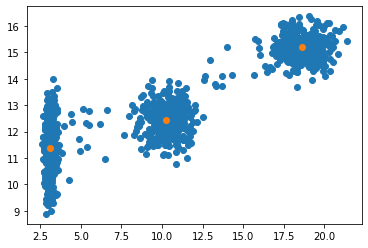

In [374]:
# PARAMETER SETTINGS
n_t = 3
mus = torch.rand((n_t, n_d)) * 20
stds = torch.rand((n_t, n_d))
#
alphas = torch.Tensor([0.01, 0.01, 0.01])
mmg = MMG(mus, stds, alphas)
#
#
# SAMPLES
n = 1000
y, h = mmg.sample(n)

# PLOT
plt.scatter(y[:,0], y[:, 1])
plt.scatter(mus[:, 0], mus[:, 1])

In [360]:
n = 10000
y, h = mmg.sample(n)
mmg.log_prob(y, h).mean()

tensor(102.7347)

In [361]:
n = 10000
y, h = mmg.samalphas = torch.Tensor([0.01, 0.01, 0.01])
mmg = MMG(mus, stds, alphas)
#
#
# SAMPLES
n = 1000
y, h = mmg.sample(n)

# PLOT
plt.scatter(y[:,0], y[:, 1])
plt.scatter(mus[:, 0], mus[:, 1])ple(n)
mmg.log_prob(y, h).mean()

tensor(103.2051)

In [363]:
n = 10000
#
mu = mus[2]
std = stds[2]
cov = torch.diag(std**2)
#
# create torch mult normal
normal_torch = MultivariateNormal(mu, cov)
#
x = [normal_torch.sample() for _ in range(n)]
x = torch.stack(x)

lp_torch = normal_torch.log_prob(x)
p_torch = torch.exp(lp_torch)
#
p_numpy = multivariate_normal.pdf(x.numpy(), mean=mu.numpy(), cov=cov.numpy())
lp_numpy = np.log(p_numpy)

# Right initialization of the MMG

# (o) Around Cricle

In [382]:
def init_mus_circle(n_t):
    r = 1
    ts = [(2*np.pi*k)/n_t for k in range(n_t)]
    xs = [r * np.cos(k) for k in ts]
    ys = [r * np.sin(k) for k in ts]
    return torch.Tensor([xs, ys]).T

def init_stds_ciricle(n_t, const=0.1):
    return torch.ones(n_t, 2) * const

def init_normals_circle(n_t, d_z):
    assert d_z == 2
    assert n_t >= 1
    
    mus = init_mus_circle(n_t)
    stds = init_stds_ciricle(n_t)
    return mus, stds

(-1.1, 1.1, -1.0461621940135957, 1.0461621940135957)

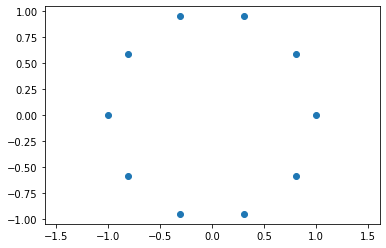

In [383]:
n_t = 10
#
mus = init_mus_circle(n_t)
#

plt.scatter(mus[:,0], mus[:,1])
plt.axis('equal')

(-0.9314340204000473,
 1.389608547091484,
 -1.2093558609485626,
 1.235971599817276)

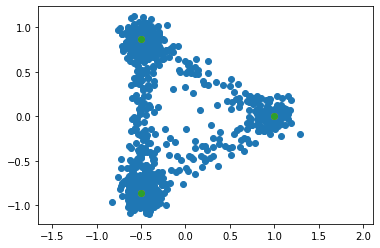

In [388]:
n_t = 3
d_z = 2
#
mus, stds = init_normals_circle(n_t, d_z)
#
alphas = torch.Tensor([0.05, 0.11, 0.11])
mmg = MMG(mus, stds, alphas)
#
#
# SAMPLES
n = 1000
y, h = mmg.sample(n)

# PLOT
plt.scatter(y[:,0], y[:, 1])
plt.scatter(mus[:, 0], mus[:, 1])
plt.scatter(mus[:,0], mus[:,1])
plt.axis('equal')

## (o) Around the unit sphere

In [318]:
# fucking hard problem -.-

## (o) Dimensionwise

In [307]:
def init_mus_dim(n_t, d_z):
    if n_t > d_z:
        raise Exception("Cannot init n_t > d_z")
    t_per_dim = 

In [310]:
d_z = 3
n_t = 2
#
t_per_dim = d_z / n_t

In [311]:
t_per_dim

1.5

In [ ]:
mus = torch.diag(torch.)

## (o) Random

## (o) Learn